# Introduction to Embeddings and Their Applications

Embeddings are numerical representations of text or other data types in a continuous vector space. They capture semantic meanings, allowing models to process and understand complex data relationships effectively.

## What Are Embeddings?

In natural language processing (NLP), embeddings convert words, phrases, or documents into vectors of real numbers. These vectors encode semantic information, enabling models to perform tasks like similarity detection, clustering, and classification.

## Applications of Embeddings

Embeddings have a wide range of applications, including:
- **Semantic Search**: Enhancing search accuracy by understanding the context and meaning behind queries and documents.
- **Clustering**: Grouping similar items together based on their semantic content.
- **Recommendation Systems**: Suggesting items to users by finding similarities in embedded representations.
- **Anomaly Detection**: Identifying outliers by analyzing distances in the embedding space.
- **Text Classification**: Categorizing text by leveraging the semantic information captured in embeddings.

## Generating Embeddings with OpenAI API

OpenAI provides powerful models to generate embeddings for various data types. Below is an example of how to generate embeddings for a list of sentences using OpenAI's API.

In [ ]:
import openai
import numpy as np
import os
from google.colab import userdata
# Set your OpenAI API key
os.environ["OPENAI_API_KEY"] = userdata.get('openai_api_key')

# List of sentences to embed
sentences = [
    "The quick brown fox jumps over the lazy dog.",
    "A fast, dark-colored fox leaps over a sleepy canine.",
    "Artificial intelligence and machine learning are transforming the world.",
    "The capital of France is Paris."
]

# Function to generate embeddings
def get_embeddings(text_list):
    response = openai.embeddings.create(
        input=text_list,
        model="text-embedding-ada-002"
    )
    embeddings = [np.array(e.embedding) for e in response.data]
    return embeddings

# Generate embeddings for the sentences
embeddings = get_embeddings(sentences)

# Display the embeddings
for i, embedding in enumerate(embeddings):
    print(f"Sentence {i+1} embedding:\n{embedding[:5]}...\n")  # Displaying the first 5 dimensions for brevity

Sentence 1 embedding:
[ 0.00157239  0.00596398 -0.0151025  -0.00855933 -0.01158359]...

Sentence 2 embedding:
[ 0.00794172 -0.00250076 -0.01671809 -0.02054984 -0.0137842 ]...

Sentence 3 embedding:
[-0.01614069 -0.00811529  0.01643602 -0.01648739  0.00241083]...

Sentence 4 embedding:
[ 0.01860841 -0.00030375 -0.00583763 -0.01745392 -0.01219043]...



In [ ]:
embedding.shape

(1536,)

## Conclusion

Embeddings are a fundamental tool in modern NLP, enabling models to capture and utilize semantic information effectively. By leveraging embeddings, we can enhance various applications, from search engines to recommendation systems.

##### Copyright 2024 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Overview

This tutorial demonstrates how to visualize and perform clustering with the embeddings from the Gemini API. You will visualize a subset of the 20 Newsgroup dataset using [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html){:.external} and cluster that subset using the KMeans algorithm.

For more information on getting started with embeddings generated from the Gemini API, check out the [Python quickstart](https://ai.google.dev/gemini-api/docs/get-started/python#use_embeddings).

## Prerequisites

You can run this quickstart in Google Colab.

To complete this quickstart on your own development environment, ensure that your envirmonement meets the following requirements:

-  Python 3.9+
-  An installation of `jupyter` to run the notebook.

## Setup

First, download and install the Gemini API Python library.

In [ ]:
!pip install -U -q google-generativeai

In [ ]:
import re
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import google.generativeai as genai

# Used to securely store your API key
from google.colab import userdata

from sklearn.datasets import fetch_20newsgroups
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Or use `os.getenv('API_KEY')` to fetch an environment variable.
from google.colab import userdata
API_KEY=userdata.get('GOOGLE_API_KEY')

genai.configure(api_key=API_KEY)

## Dataset

The [20 Newsgroups Text Dataset](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html) contains 18,000 newsgroups posts on 20 topics divided into training and test sets. The split between the training and test datasets are based on messages posted before and after a specific date. For this tutorial, you will be using the training subset.

In [ ]:
newsgroups_train = fetch_20newsgroups(subset='train')

# View list of class names for dataset
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Here is the first example in the training set.

In [ ]:
idx = newsgroups_train.data[0].index('Lines')
print(newsgroups_train.data[0][idx:])

Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [ ]:
# Apply functions to remove names, emails, and extraneous words from data points in newsgroups.data
newsgroups_train.data = [re.sub(r'[\w\.-]+@[\w\.-]+', '', d) for d in newsgroups_train.data] # Remove email
newsgroups_train.data = [re.sub(r"\([^()]*\)", "", d) for d in newsgroups_train.data] # Remove names
newsgroups_train.data = [d.replace("From: ", "") for d in newsgroups_train.data] # Remove "From: "
newsgroups_train.data = [d.replace("\nSubject: ", "") for d in newsgroups_train.data] # Remove "\nSubject: "

In [ ]:
type(newsgroups_train.data)

list

In [ ]:
df_train = pd.DataFrame(newsgroups_train.data, columns=['Text'])
df_train['Label'] = newsgroups_train.target

df_train

,Text,Label
0,WHAT car is this!?\nNntp-Posting-Host: rac3.w...,7
1,SI Clock Poll - Final Call\nSummary: Final ca...,4
2,PB questions...\nOrganization: Purdue Univers...,4
3,Re: Weitek P9000 ?\nOrganization: Harris Comp...,1
4,Re: Shuttle Launch Question\nOrganization: Sm...,14
...,...,...
11309,Re: Migraines and scans\nDistribution: world...,13
11310,Screen Death: Mac Plus/512\nLines: 22\nOrganiz...,4
11311,Mounting CPU Cooler in vertical case\nOrganiz...,3
11312,Re: Sphere from 4 points?\nOrganization: Cent...,1


In [ ]:
newsgroups_train.target.shape

(11314,)

In [ ]:
# Put training points into a dataframe
df_train = pd.DataFrame(newsgroups_train.data, columns=['Text'])
df_train['Label'] = newsgroups_train.target
# Match label to target name index
df_train['Class Name'] = df_train['Label'].map(newsgroups_train.target_names.__getitem__)
# Retain text samples that can be used in the gecko model.
df_train = df_train[df_train['Text'].str.len() < 8000]

df_train

,Text,Label,Class Name
0,WHAT car is this!?\nNntp-Posting-Host: rac3.w...,7,rec.autos
1,SI Clock Poll - Final Call\nSummary: Final ca...,4,comp.sys.mac.hardware
2,PB questions...\nOrganization: Purdue Univers...,4,comp.sys.mac.hardware
3,Re: Weitek P9000 ?\nOrganization: Harris Comp...,1,comp.graphics
4,Re: Shuttle Launch Question\nOrganization: Sm...,14,sci.space
...,...,...,...
11309,Re: Migraines and scans\nDistribution: world...,13,sci.med
11310,Screen Death: Mac Plus/512\nLines: 22\nOrganiz...,4,comp.sys.mac.hardware
11311,Mounting CPU Cooler in vertical case\nOrganiz...,3,comp.sys.ibm.pc.hardware
11312,Re: Sphere from 4 points?\nOrganization: Cent...,1,comp.graphics


Next, you will sample some of the data by taking 100 data points in the training dataset, and dropping a few of the categories to run through this tutorial. Choose the science categories to compare.

In [ ]:
# Take a sample of each label category from df_train
SAMPLE_SIZE = 150
df_train = (df_train.groupby('Label', as_index = False)
                    .apply(lambda x: x.sample(SAMPLE_SIZE))
                    .reset_index(drop=True))

# Choose categories about science
df_train = df_train[df_train['Class Name'].str.contains('sci')]

# Reset the index
df_train = df_train.reset_index()
df_train

<ipython-input-53-c979cf6a7a32>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(SAMPLE_SIZE))


,index,Text,Label,Class Name
0,1650,Re: An Open Letter to Mr. Clinton\nOrganizati...,11,sci.crypt
1,1651,"Re: Once tapped, your code is no good any mor...",11,sci.crypt
2,1652,Re: Secret algorithm [Re: Clipper Chip and cr...,11,sci.crypt
3,1653,Marc VanHeyningen <>Re: freely distributable p...,11,sci.crypt
4,1654,Re: White House Public Encryption Management ...,11,sci.crypt
...,...,...,...,...
595,2245,Re: Why not give $1 billion to first year-lon...,14,sci.space
596,2246,I want that Billion\nOrganization: Computer A...,14,sci.space
597,2247,Re: Talking to Boeing management about SSTO t...,14,sci.space
598,2248,NASP\nX-Added: Forwarded by Space Digest\nOrg...,14,sci.space


In [ ]:
df_train['Class Name'].value_counts()

,count
Class Name,
sci.crypt,150
sci.electronics,150
sci.med,150
sci.space,150


## Create the embeddings

In this section, you will see how to generate embeddings for the different texts in the dataframe using the embeddings from the Gemini API.

### API changes to Embeddings with model embedding-001

For the new embeddings model, embedding-001, there is a new task type parameter and the optional title (only valid with task_type=`RETRIEVAL_DOCUMENT`).

These new parameters apply only to the newest embeddings models.The task types are:

Task Type | Description
---       | ---
RETRIEVAL_QUERY	| Specifies the given text is a query in a search/retrieval setting.
RETRIEVAL_DOCUMENT | Specifies the given text is a document in a search/retrieval setting.
SEMANTIC_SIMILARITY	| Specifies the given text will be used for Semantic Textual Similarity (STS).
CLASSIFICATION	| Specifies that the embeddings will be used for classification.
CLUSTERING	| Specifies that the embeddings will be used for clustering.

In [ ]:
from tqdm.auto import tqdm
tqdm.pandas()

from google.api_core import retry

def make_embed_text_fn(model):

  @retry.Retry(timeout=300.0)
  # def embed_fn(text: str) -> list[float]:
  #   # Set the task_type to CLUSTERING.
  #   embedding = genai.embed_content(model=model,
  #                                   content=text,
  #                                   task_type="clustering")
  #   return embedding["embedding"]
  def get_embeddings(text_list):
      response = openai.embeddings.create(
          input=text_list,
          model="text-embedding-ada-002"
      )
      embeddings = [np.array(e.embedding) for e in response.data]
      return embeddings[0]
  return get_embeddings

def create_embeddings(df):
  model = "text-embedding-ada-002"
  df['Embeddings'] = df['Text'].progress_apply(make_embed_text_fn(model))
  return df

df_train = create_embeddings(df_train)

  0%|          | 0/600 [00:00<?, ?it/s]

## Dimensionality reduction

The length of the document embedding vector is 768. In order to visualize how the embedded documents are grouped together, you will need to apply dimensionality reduction as you can only visualize the embeddings in 2D or 3D space. Contextually similar documents should be closer together in space as opposed to documents that are not as similar.

In [ ]:
df_train

,index,Text,Label,Class Name,Embeddings
0,1650,Re: An Open Letter to Mr. Clinton\nOrganizati...,11,sci.crypt,"[-0.001686088158749044, -0.02224973402917385, ..."
1,1651,"Re: Once tapped, your code is no good any mor...",11,sci.crypt,"[-0.019677678123116493, -0.019768428057432175,..."
2,1652,Re: Secret algorithm [Re: Clipper Chip and cr...,11,sci.crypt,"[-0.005003413651138544, -0.007056837435811758,..."
3,1653,Marc VanHeyningen <>Re: freely distributable p...,11,sci.crypt,"[-0.020310601219534874, -0.004053465090692043,..."
4,1654,Re: White House Public Encryption Management ...,11,sci.crypt,"[-0.015620666556060314, 0.0036311198491603136,..."
...,...,...,...,...,...
595,2245,Re: Why not give $1 billion to first year-lon...,14,sci.space,"[0.008252421393990517, -0.0023640887811779976,..."
596,2246,I want that Billion\nOrganization: Computer A...,14,sci.space,"[-0.0073224580846726894, 0.012472775764763355,..."
597,2247,Re: Talking to Boeing management about SSTO t...,14,sci.space,"[-0.006798481568694115, -0.031699854880571365,..."
598,2248,NASP\nX-Added: Forwarded by Space Digest\nOrg...,14,sci.space,"[-0.006157990079373121, -0.0002891420153900981..."


In [ ]:
len(df_train['Embeddings'][0])

1536

In [ ]:
# Convert df_train['Embeddings'] Pandas series to a np.array of float32
X = np.array(df_train['Embeddings'].to_list(), dtype=np.float32)
X.shape

(600, 1536)

In [ ]:
X[0].shape

(1536,)

You will apply the t-Distributed Stochastic Neighbor Embedding (t-SNE) approach to perform dimensionality reduction. This technique reduces the number of dimensions, while preserving clusters (points that are close together stay close together). For the original data, the model tries to construct a distribution over which other data points are "neighbors" (e.g., they share a similar meaning). It then optimizes an objective function to keep a similar distribution in the visualization.

In [ ]:
tsne = TSNE(random_state=0, n_iter=1000)
tsne_results = tsne.fit_transform(X)

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [ ]:
df_tsne = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
df_tsne

,TSNE1,TSNE2
0,-17.590300,-3.493541
1,-10.987262,0.561792
2,-26.883688,-11.349025
3,-32.386772,-16.498140
4,-13.772853,-8.076204
...,...,...
595,32.424023,13.081631
596,22.184675,-3.900559
597,34.723797,-3.258484
598,28.839346,-2.984938


In [ ]:
df_tsne = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
df_tsne['Class Name'] = df_train['Class Name'] # Add labels column from df_train to df_tsne
df_tsne

,TSNE1,TSNE2,Class Name
0,-17.590300,-3.493541,sci.crypt
1,-10.987262,0.561792,sci.crypt
2,-26.883688,-11.349025,sci.crypt
3,-32.386772,-16.498140,sci.crypt
4,-13.772853,-8.076204,sci.crypt
...,...,...,...
595,32.424023,13.081631,sci.space
596,22.184675,-3.900559,sci.space
597,34.723797,-3.258484,sci.space
598,28.839346,-2.984938,sci.space


(-39.95475769042969, 44.70098114013672, -38.796875, 43.95606994628906)

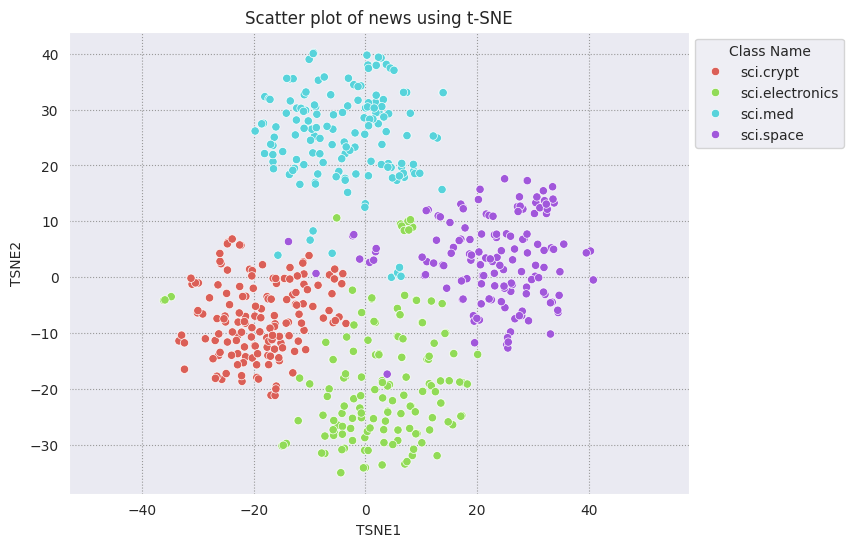

In [ ]:
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Class Name', palette='hls')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news using t-SNE');
plt.xlabel('TSNE1');
plt.ylabel('TSNE2');
plt.axis('equal')

## Compare results to KMeans

[KMeans clustering](https://developers.google.com/machine-learning/glossary#k-means) is a popular clustering algorithm and used often for unsupervised learning. It iteratively determines the best k center points, and assigns each example to the closest centroid. Input the embeddings directly into the KMeans algorithm to compare the visualization of the embeddings to the performance of a machine learning algorithm.

In [ ]:
# Apply KMeans
kmeans_model = KMeans(n_clusters=4, random_state=1, n_init='auto').fit(X)
labels = kmeans_model.fit_predict(X)

In [ ]:
df_tsne['Cluster'] = labels
df_tsne

,TSNE1,TSNE2,Class Name,Cluster
0,-17.590300,-3.493541,sci.crypt,2
1,-10.987262,0.561792,sci.crypt,2
2,-26.883688,-11.349025,sci.crypt,2
3,-32.386772,-16.498140,sci.crypt,2
4,-13.772853,-8.076204,sci.crypt,2
...,...,...,...,...
595,32.424023,13.081631,sci.space,1
596,22.184675,-3.900559,sci.space,1
597,34.723797,-3.258484,sci.space,1
598,28.839346,-2.984938,sci.space,1


(-39.95475769042969, 44.70098114013672, -38.796875, 43.95606994628906)

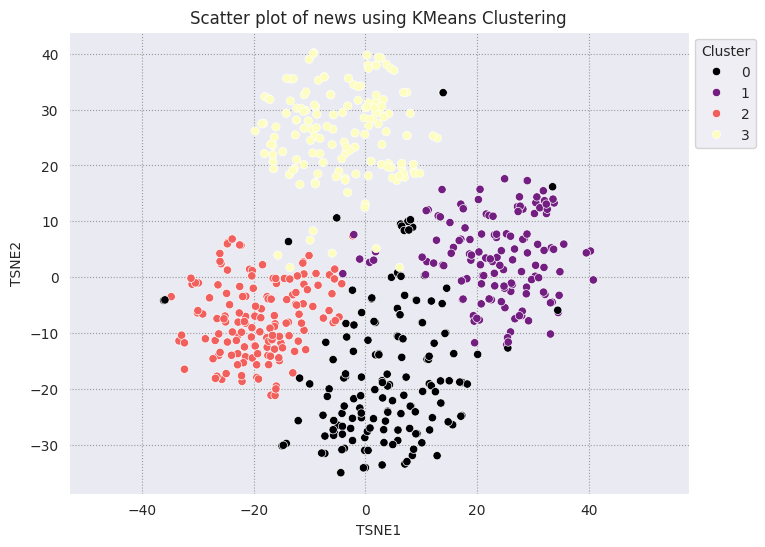

In [ ]:
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Cluster', palette='magma')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news using KMeans Clustering');
plt.xlabel('TSNE1');
plt.ylabel('TSNE2');
plt.axis('equal')

In [ ]:
def get_majority_cluster_per_group(df_tsne_cluster, class_names):
  class_clusters = dict()
  for c in class_names:
    # Get rows of dataframe that are equal to c
    rows = df_tsne_cluster.loc[df_tsne_cluster['Class Name'] == c]
    # Get majority value in Cluster column of the rows selected
    cluster = rows.Cluster.mode().values[0]
    # Populate mapping dictionary
    class_clusters[c] = cluster
  return class_clusters

In [ ]:
classes = df_tsne['Class Name'].unique()
class_clusters = get_majority_cluster_per_group(df_tsne, classes)
class_clusters

{'sci.crypt': 2, 'sci.electronics': 0, 'sci.med': 3, 'sci.space': 1}

Get the majority of clusters per group, and see how many of the actual members of that group are in that cluster.

## Next steps

You've now created your own visualization of embeddings with clustering! Try using your own textual data to visualize them as embeddings. You can perform dimensionality reduction in order to complete the visualization step. Note that TSNE is good at clustering inputs, but can take a longer time to converge or might get stuck at local minima. If you run into this issue, another technique you could consider are [principal components analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis)

# Training a Text Classifier Using Embeddings

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://ai.google.dev/gemini-api/tutorials/text_classifier_embeddings"><img src="https://ai.google.dev/static/site-assets/images/docs/notebook-site-button.png" height="32" width="32" />View on ai.google.dev</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/generative-ai-docs/blob/main/site/en/gemini-api/tutorials/text_classifier_embeddings.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/generative-ai-docs/blob/main/site/en/gemini-api/tutorials/text_classifier_embeddings.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Overview

In this notebook, you'll learn to use the embeddings produced by the Gemini API to train a model that can classify different types of newsgroup posts based on the topic.

In this tutorial, you'll train a classifier to predict which class a newsgroup post belongs to.

## Prerequisites

You can run this quickstart in Google Colab.

To complete this quickstart on your own development environment, ensure that your envirmonement meets the following requirements:

-  Python 3.9+
-  An installation of `jupyter` to run the notebook.

## Setup

First, download and install the Gemini API Python library.

In [ ]:
import re
import tqdm
import keras
import numpy as np
import pandas as pd

import google.generativeai as genai

# Used to securely store your API key
from google.colab import userdata

import seaborn as sns
import matplotlib.pyplot as plt

from keras import layers
from matplotlib.ticker import MaxNLocator
from sklearn.datasets import fetch_20newsgroups
import sklearn.metrics as skmetrics

Key Point: Next, you will choose a model. Any embedding model will work for this tutorial, but for real applications it's important to choose a specific model and stick with it. The outputs of different models are not compatible with each other.

## Dataset

The [20 Newsgroups Text Dataset](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html)contains 18,000 newsgroups posts on 20 topics divided into training and test sets. The split between the training and test datasets are based on messages posted before and after a specific date. For this tutorial, you will be using the subsets of the training and test datasets. You will preprocess and organize the data into Pandas dataframes.

In [ ]:
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

# View list of class names for dataset
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Here is an example of what a data point from the training set looks like.

In [ ]:
idx = newsgroups_train.data[0].index('Lines')
print(newsgroups_train.data[0][idx:])

Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







Now you will begin preprocessing the data for this tutorial. Remove any sensitive information like names, email, or redundant parts of the text like `"From: "` and `"\nSubject: "`. Organize the information into a Pandas dataframe so it is more readable.

In [ ]:
def preprocess_newsgroup_data(newsgroup_dataset):
  # Apply functions to remove names, emails, and extraneous words from data points in newsgroups.data
  newsgroup_dataset.data = [re.sub(r'[\w\.-]+@[\w\.-]+', '', d) for d in newsgroup_dataset.data] # Remove email
  newsgroup_dataset.data = [re.sub(r"\([^()]*\)", "", d) for d in newsgroup_dataset.data] # Remove names
  newsgroup_dataset.data = [d.replace("From: ", "") for d in newsgroup_dataset.data] # Remove "From: "
  newsgroup_dataset.data = [d.replace("\nSubject: ", "") for d in newsgroup_dataset.data] # Remove "\nSubject: "

  # Cut off each text entry after 5,000 characters
  newsgroup_dataset.data = [d[0:8000] if len(d) > 8000 else d for d in newsgroup_dataset.data]

  # Put data points into dataframe
  df_processed = pd.DataFrame(newsgroup_dataset.data, columns=['Text'])
  df_processed['Label'] = newsgroup_dataset.target
  # Match label to target name index
  df_processed['Class Name'] = ''
  for idx, row in df_processed.iterrows():
    df_processed.at[idx, 'Class Name'] = newsgroup_dataset.target_names[row['Label']]

  return df_processed

In [ ]:
# Apply preprocessing function to training and test datasets
df_train = preprocess_newsgroup_data(newsgroups_train)
df_test = preprocess_newsgroup_data(newsgroups_test)

df_train.head(10)

,Text,Label,Class Name
0,WHAT car is this!?\nNntp-Posting-Host: rac3.w...,7,rec.autos
1,SI Clock Poll - Final Call\nSummary: Final ca...,4,comp.sys.mac.hardware
2,PB questions...\nOrganization: Purdue Univers...,4,comp.sys.mac.hardware
3,Re: Weitek P9000 ?\nOrganization: Harris Comp...,1,comp.graphics
4,Re: Shuttle Launch Question\nOrganization: Sm...,14,sci.space
5,Re: Rewording the Second Amendment \nOrganiza...,16,talk.politics.guns
6,Brain Tumor Treatment \nReply-To: \nOrganizat...,13,sci.med
7,Re: IDE vs SCSI\nOrganization: New Mexico Sta...,3,comp.sys.ibm.pc.hardware
8,WIn 3.0 ICON HELP PLEASE!\nOrganization: Unive...,2,comp.os.ms-windows.misc
9,Re: Sigma Designs Double up??\nArticle-I.D.: ...,4,comp.sys.mac.hardware


Next, you will sample some of the data by taking 100 data points in the training dataset, and dropping a few of the categories to run through this tutorial. Choose the science categories to compare.

In [ ]:
def sample_data(df, num_samples, classes_to_keep):
  df = df.groupby('Label', as_index = False).apply(lambda x: x.sample(num_samples)).reset_index(drop=True)

  df = df[df['Class Name'].str.contains(classes_to_keep)]

  # Reset the encoding of the labels after sampling and dropping certain categories
  df['Class Name'] = df['Class Name'].astype('category')
  df['Encoded Label'] = df['Class Name'].cat.codes

  return df

In [ ]:
TRAIN_NUM_SAMPLES = 100
TEST_NUM_SAMPLES = 25
CLASSES_TO_KEEP = 'sci' # Class name should contain 'sci' in it to keep science categories
df_train = sample_data(df_train, TRAIN_NUM_SAMPLES, CLASSES_TO_KEEP)
df_test = sample_data(df_test, TEST_NUM_SAMPLES, CLASSES_TO_KEEP)

<ipython-input-106-4e962cbdf09d>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Label', as_index = False).apply(lambda x: x.sample(num_samples)).reset_index(drop=True)
<ipython-input-106-4e962cbdf09d>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Label', as_index = False).apply(lambda x: x.sample(num_samples)).reset_index(drop=True)


In [ ]:
df_test

,Text,Label,Class Name,Encoded Label
275,Re: Tempest\nOrganization: Express Access Onl...,11,sci.crypt,0
276,Re: Tempest\nDistribution: na\nOrganization: ...,11,sci.crypt,0
277,Re: Is it illegal to transmit encrypted data?...,11,sci.crypt,0
278,What would happen if export restrictions viol...,11,sci.crypt,0
279,Reply-To: \n Re: New Encryption Algorithm\nLi...,11,sci.crypt,0
...,...,...,...,...
370,Re: What planets are habitable\nOrganization:...,14,sci.space,3
371,Re: Gamma Ray Bursters How energetic could th...,14,sci.space,3
372,Re: Human Habitale Planets?\nNntp-Posting-Hos...,14,sci.space,3
373,Re: HST Servicing Mission Scheduled for 11 Da...,14,sci.space,3


In [ ]:
df_train.value_counts('Class Name')

,count
Class Name,
sci.crypt,100
sci.electronics,100
sci.med,100
sci.space,100


In [ ]:
df_test.value_counts('Class Name')

,count
Class Name,
sci.crypt,25
sci.electronics,25
sci.med,25
sci.space,25


## Create the embeddings

In this section, you will see how to generate embeddings for a piece of text using the embeddings from the Gemini API. To learn more about embeddings, visit the [embeddings guide](https://ai.google.dev/docs/embeddings_guide).

**NOTE**: Embeddings are computed one at a time, large sample sizes can take a long time!

### API changes to Embeddings embedding-001

For the new embeddings model, there is a new task type parameter and the optional title (only valid with task_type=`RETRIEVAL_DOCUMENT`).

These new parameters apply only to the newest embeddings models.The task types are:

Task Type | Description
---       | ---
RETRIEVAL_QUERY	| Specifies the given text is a query in a search/retrieval setting.
RETRIEVAL_DOCUMENT | Specifies the given text is a document in a search/retrieval setting.
SEMANTIC_SIMILARITY	| Specifies the given text will be used for Semantic Textual Similarity (STS).
CLASSIFICATION	| Specifies that the embeddings will be used for classification.
CLUSTERING	| Specifies that the embeddings will be used for clustering.

In [ ]:
from tqdm.auto import tqdm
tqdm.pandas()

from google.api_core import retry

def make_embed_text_fn(model):

  @retry.Retry(timeout=300.0)
  def get_embeddings(text_list):
      response = openai.embeddings.create(
          input=text_list,
          model="text-embedding-ada-002"
      )
      embeddings = [np.array(e.embedding) for e in response.data]
      return embeddings[0]
  return get_embeddings


def create_embeddings(model, df):
  df['Embeddings'] = df['Text'].progress_apply(make_embed_text_fn(model))
  return df

In [ ]:
model="text-embedding-ada-002"
df_train = create_embeddings(model, df_train)


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
df_test = create_embeddings(model, df_test)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
df_train.head()

,Text,Label,Class Name,Encoded Label,Embeddings
1100,Re: What is going on?...\nLines: 27\nOrganiza...,11,sci.crypt,0,"[-0.025044765323400497, -0.011986123397946358,..."
1101,"Screw the people, crypto is for hard-core hac...",11,sci.crypt,0,"[-0.0048323730006814, -0.010960409417748451, 0..."
1102,"Re: Once tapped, your code is no good any mor...",11,sci.crypt,0,"[-0.025413375347852707, 0.0003786761371884495,..."
1103,"Re: Once tapped, your code is no good any more...",11,sci.crypt,0,"[-0.0025394351687282324, -0.016235142946243286..."
1104,Underground encryption \nOrganization: Univer...,11,sci.crypt,0,"[-0.0057715787552297115, -0.011622467078268528..."


## Build a simple classification model
Here you will define a simple model with one hidden layer and a single class probability output. The prediction will correspond to the probability of a piece of text being a particular class of news. When you build your model, Keras will automatically shuffle the data points.

In [ ]:
def build_classification_model(input_size: int, num_classes: int) -> keras.Model:
  inputs = x =keras.Input(shape=(input_size,))
  x = layers.Dense(input_size, activation='relu')(x)
  x = layers.Dense(num_classes, activation='sigmoid')(x)
  return keras.Model(inputs=[inputs], outputs=x)

In [ ]:
embedding_size

1536

In [ ]:
# Derive the embedding size from the first training element.
embedding_size = len(df_train['Embeddings'].iloc[0])

# Give your model a different name, as you have already used the variable name 'model'
classifier = build_classification_model(embedding_size, len(df_train['Class Name'].unique()))
classifier.summary()

classifier.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   optimizer = keras.optimizers.Adam(learning_rate=0.001),
                   metrics=['accuracy'])

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, 1536)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1536)                │       2,360,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 4)                   │           6,148 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,366,980 (9.03 MB)

 Trainable params: 2,366,980 (9.03 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
embedding_size

768

## Train the model to classify newsgroups

Finally, you can train a simple model. Use a small number of epochs to avoid overfitting. The first epoch takes much longer than the rest, because the embeddings need to be computed only once.

In [ ]:
NUM_EPOCHS = 20
BATCH_SIZE = 32

# Split the x and y components of the train and validation subsets.
y_train = df_train['Encoded Label']
x_train = np.stack(df_train['Embeddings'])
y_val = df_test['Encoded Label']
x_val = np.stack(df_test['Embeddings'])

# Train the model for the desired number of epochs.
callback = keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)

history = classifier.fit(x=x_train,
                         y=y_train,
                         validation_data=(x_val, y_val),
                         callbacks=[callback],
                         batch_size=BATCH_SIZE,
                         epochs=NUM_EPOCHS,)

KeyError: 'Encoded Label'

## Evaluate model performance

Use Keras <a href="https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate"><code>Model.evaluate</code></a> to get the loss and accuracy on the test dataset.

In [ ]:
classifier.evaluate(x=x_val, y=y_val, return_dict=True)

4/4 [==============================] - 0s 4ms/step - loss: 0.1070 - accuracy: 0.9700


{'loss': 0.10700511932373047, 'accuracy': 0.9700000286102295}

One way to evaluate your model performance is to visualize the classifier performance. Use `plot_history` to see the loss and accuracy trends over the epochs.

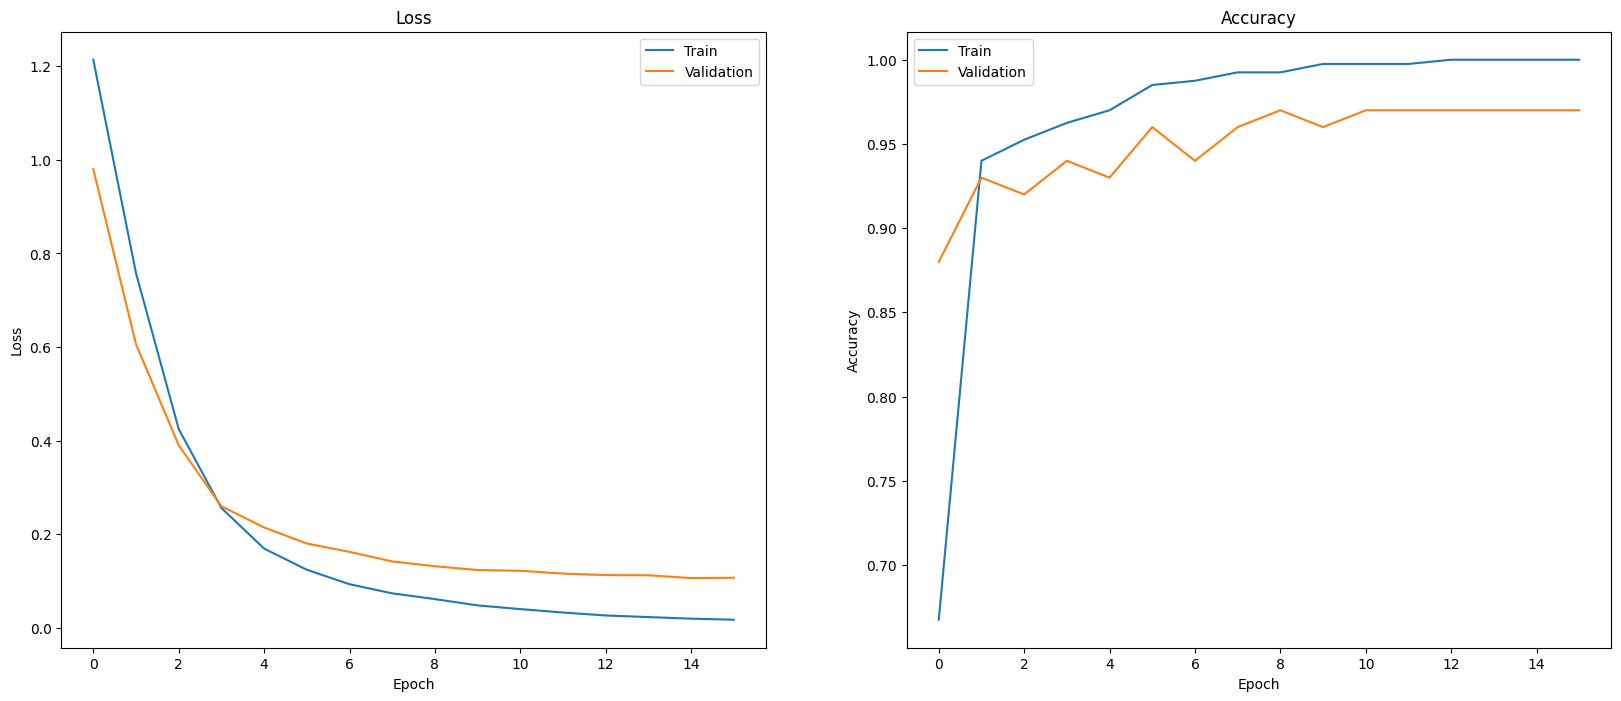

In [ ]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(1,2)
  fig.set_size_inches(20, 8)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')

  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation'])

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)

Another way to view model performance, beyond just measuring loss and accuracy is to use a confusion matrix. The confusion matrix allows you to assess the performance of the classification model beyond accuracy. You can see what misclassified points get classified as. In order to build the confusion matrix for this multi-class classification problem, get the actual values in the test set and the predicted values.

Start by generating the predicted class for each example in the validation set using [`Model.predict()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict).

In [ ]:
y_hat = classifier.predict(x=x_val)
y_hat = np.argmax(y_hat, axis=1)

4/4 [==============================] - 0s 4ms/step


In [ ]:
labels_dict = dict(zip(df_test['Class Name'], df_test['Encoded Label']))
labels_dict

{'sci.crypt': 0, 'sci.electronics': 1, 'sci.med': 2, 'sci.space': 3}

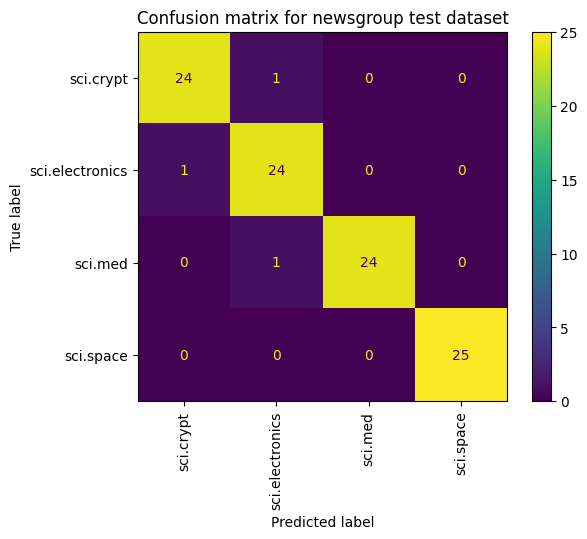

In [ ]:
cm = skmetrics.confusion_matrix(y_val, y_hat)
disp = skmetrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels_dict.keys())
disp.plot(xticks_rotation='vertical')
plt.title('Confusion matrix for newsgroup test dataset');
plt.grid(False)

## Next steps

To learn how to use other services in the Gemini API, see the [Python quickstart](https://ai.google.dev/tutorials/python_quickstart).

To learn more about how you can use embeddings, see these  other tutorials:

 * [Anomaly Detection with Embeddings](https://ai.google.dev/gemini-api/tutorials/anomaly_detection)
 * [Clustering with Embeddings](https://ai.google.dev/gemini-api/tutorials/clustering_with_embeddings)
 * [Document Search with Embeddings](https://ai.google.dev/gemini-api/tutorials/document_search)
